In [1]:
# imports
import psycopg2
import numpy as np
import pandas as pd
import json
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from scipy import interpolate

import torch
import torch.nn
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import ParameterGrid


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer


from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import CoxPHFitter

from sksurv.ensemble import RandomSurvivalForest

from pycox.datasets import metabric
from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv

import torchtuples as tt

from auton_survival.models.dsm import DeepSurvivalMachines

from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc

In [2]:
resolution = 100 # can head to config file

# access creds
with open('psql_key.json') as file:
    creds = json.load(file)

# Create an SQLAlchemy engine with the PostgreSQL database URI
engine = create_engine(f"postgresql+psycopg2://{creds['user']}:{creds['password']}@{creds['host']}:{creds['port']}/{creds['database']}")

In [6]:
# these diag codes were taken from table mimiciv_hosp.d_icd_diagnoses
hf_codes = '''('39891','40200','40201','40210','40211','40290','40291','40400','40401','40402','40403','40410','40411','40412',
'40413','40490','40491','40492','40493','4280','4281','42820','42821','42822','42823','42830','42831','42832','42833','42840','42841',
'42842','42843','4289','E8726','E8745','I0981','I110','I119','I130','I131','I1310','I1311','I132','I50','I501','I502','I5020','I5021','I5022',
'I5023','I503','I5030','I5031','I5032','I5033','I504','I5040','I5041','I5042','I5043','I508','I5081','I50810','I50811','I50812','I50813','I50814',
'I5082','I5083','I5084','I5089','I509','I9713','I97130','I97131','T8622','T8632','Y625')'''

# get all admissions related to HF codes
query = f'''
select distinct a.subject_id , a.hadm_id , a.admittime , a.dischtime , p.gender , p.anchor_age , p.dod 
--e.medication
from (select hadm_id from mimiciv_hosp.diagnoses_icd where icd_code in {hf_codes}) d
inner join (select * from mimiciv_hosp.admissions) a
on a.hadm_id = d.hadm_id
inner join (select * from mimiciv_hosp.patients) p
on p.subject_id = a.subject_id
--inner join (select hadm_id , medication from mimiciv_hosp.emar) e
--on e.hadm_id = d.hadm_id
'''

all_hf_pats_0 = pd.read_sql_query(query , engine)

all_hf_pats_0['dod'] = pd.to_datetime(all_hf_pats_0['dod']).dt.date
all_hf_pats_0['admittime'] = all_hf_pats_0['admittime'].dt.date
all_hf_pats_0['dischtime'] = all_hf_pats_0['dischtime'].dt.date

# Get online medical record data (OMR)
reqd_results = ("BMI (kg/m2)" , "Height (Inches)" , "Weight (Lbs)") # Not including BP as I can get it from vitalsigns  
q = f'''select * from mimiciv_hosp.omr where result_name in {reqd_results}'''

omr = pd.read_sql_query(q , engine)
# omr_pivot = pd.read_sql_query(q , engine)
omr_first = omr.sort_values(['subject_id' , 'chartdate'] , ascending = True).groupby(['subject_id' , 'result_name']).first().reset_index()
omr_pivot = omr_first.pivot(index = 'subject_id', columns = 'result_name' , values = 'result_value').reset_index()
omr_pivot.dropna(inplace = True)

# Join
all_hf_pats = pd.merge(all_hf_pats_0 , omr_pivot , on = 'subject_id' , how = 'inner')

# QC
print(all_hf_pats['subject_id'].nunique())
all_hf_pats.head(2)

15628


,subject_id,hadm_id,admittime,dischtime,gender,anchor_age,dod,BMI (kg/m2),Height (Inches),Weight (Lbs)
0,18591383,20057039,2183-06-21,2183-06-22,M,81,2185-04-04,21.1,66,131
1,18591383,23411231,2184-06-16,2184-07-02,M,81,2185-04-04,21.1,66,131


In [12]:
# Count of times patients have been admitted with a HF diagnosis

hist_df = all_hf_pats.groupby('subject_id').agg({'admittime':'nunique'}).reset_index().groupby('admittime').agg({'subject_id':'nunique'}).reset_index()
hist_df.columns = ['num_admits' , 'patients']
hist_df['cumulative_patients'] = hist_df['patients'].cumsum()
# hist_df

In [5]:
# Retain all patients
# Add num of ICU admits / num of admissions as covariates
# Time of survival -> from last ICU admission to deathtime / OR first ICU admission?
# Uncensored patients (those that experienced the event, i.e. died)
# Find latest ICU admission
tos_hf = all_hf_pats.groupby('subject_id').agg({'admittime':'min' , 'dod':'max' , 'dischtime':'max'})
event_pats = tos_hf[tos_hf['dod'].notnull()].copy()
event_pats['time_to_event'] = event_pats['dod'] - event_pats['admittime']
event_pats['time_to_event'] = event_pats['time_to_event'] / np.timedelta64(1, 'D') # convert to hours
event_pats['death'] = 1
# event_pats.head(3)

In [6]:
# who are the censored patients?
non_event_pats = tos_hf[tos_hf['dod'].isnull()].copy()# For censored patients, their last follow-up was essentially their discharge time
non_event_pats['time_to_event'] = non_event_pats['dischtime'] - non_event_pats['admittime']
non_event_pats['time_to_event'] = non_event_pats['time_to_event'] / np.timedelta64(1, 'D') # convert to hours
# non_event_pats['time_to_event'] = non_event_pats['time_to_event'] + 365 # is this necessary?
non_event_pats['death'] = 0
# non_event_pats.head(3)

In [7]:
pats = pd.concat([non_event_pats[['time_to_event' , 'death']] , event_pats[['time_to_event' , 'death']]] , axis = 0)
pats.reset_index(inplace = True)
pats.sort_values('subject_id' , inplace = True)

pats['time_to_event'] = pats['time_to_event'].apply(lambda x: x+1 if x==0 else x)

pats.count()

subject_id       24348
time_to_event    24348
death            24348
dtype: int64

In [8]:
# Try to get vital signs

query = f'''
select subject_id , temperature , heartrate , resprate , o2sat , sbp , dbp from mimiciv_ed.vitalsign
'''
vitalsign = pd.read_sql_query(query , engine)
# pats_vitalsign = vitalsign.merge(pats['subject_id'] , on = 'subject_id' , how = 'inner')
# pats_vitalsign_list = pats_vitalsign.subject_id.unique()
# print(f'unique patients: {pats_vitalsign.subject_id.nunique()}')

# # Get survival
# pats_survival = pats.merge(vitalsign['subject_id'] , on = 'subject_id' , how = 'inner')
# print(f'unique patients: {pats_survival.subject_id.nunique()}')
# pats_survival.tail()

pats_all_metrics_0 = vitalsign.merge(pats , on = 'subject_id' , how = 'inner')
print(f'unique patients: {pats_all_metrics_0.subject_id.nunique()}')
# pats_all_metrics.tail()
print(f'unique records: {len(pats_all_metrics_0)}')

# Aggregate
pats_all_metrics = pats_all_metrics_0.groupby('subject_id').mean()

# Add more covariates
pats_all_metrics = pats_all_metrics.merge(all_hf_pats[['subject_id' , 'gender' , 'anchor_age']].drop_duplicates() , on = 'subject_id' , how = 'inner')

unique patients: 16117
unique records: 331116


In [9]:
pats_all_metrics_0.head(2)

,subject_id,temperature,heartrate,resprate,o2sat,sbp,dbp,time_to_event,death
0,10000980,94.8,57.0,18.0,98.0,151.0,84.0,2062.0,1
1,10000980,96.3,63.0,20.0,100.0,143.0,90.0,2062.0,1


In [10]:
# How are the censored v uncensored counts?
pats_all_metrics.groupby('death')['time_to_event'].count()

death
0.0    9646
1.0    6471
Name: time_to_event, dtype: int64

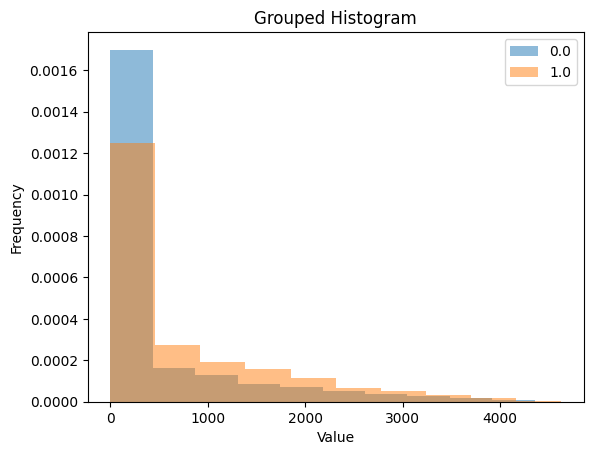

In [11]:
grouped = pats_all_metrics.groupby('death')

# Plot grouped histogram
fig, ax = plt.subplots()
for category, group in grouped:
    ax.hist(group['time_to_event'], label=category, alpha=0.5, bins=10 , density = True)

ax.legend()
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Grouped Histogram')
plt.show()

## **Fits**

In [12]:
class ModifiedLabelEncoder(LabelEncoder):

    def fit_transform(self, y, *args, **kwargs):
        return super().fit_transform(y).reshape(-1, 1)

    def transform(self, y, *args, **kwargs):
        return super().transform(y).reshape(-1, 1)

In [13]:
def train_test_splitter(df , test_size = 0.2 , val_size = 0.2 , duration_col = 'futime' , event_col = 'death'):
    df_test = df.sample(frac=test_size)
    df_train = df.drop(df_test.index)

    df_val = df_train.sample(frac=val_size)
    df_train = df_train.drop(df_val.index)

    return df_train , df_val , df_test

#### **Non Param**

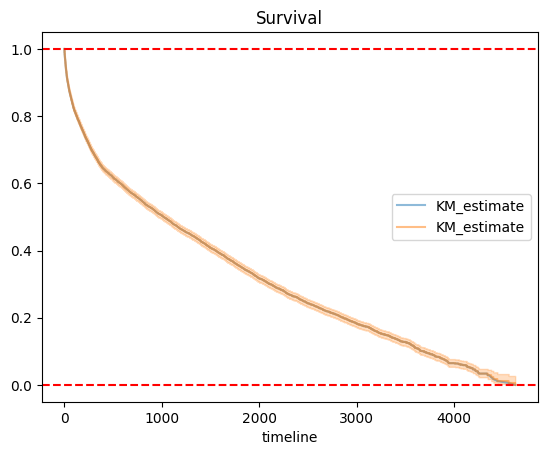

In [14]:
kmf = KaplanMeierFitter()

T = pats_all_metrics["time_to_event"]
E = pats_all_metrics["death"]

kmf.fit(T, event_observed=E)

kmf.survival_function_.plot(alpha = 0.5)

plt.title('Survival');

kmf.plot_survival_function(alpha = 0.5);

# Drawing a horizontal line at y = 7
plt.axhline(y=0., color='r', linestyle='--')
plt.axhline(y=1., color='r', linestyle='--')

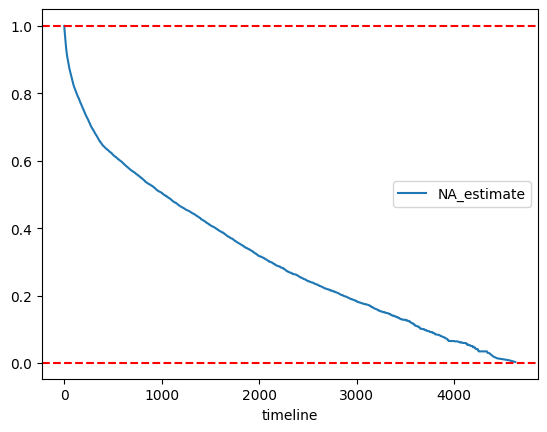

In [15]:
naf = NelsonAalenFitter()

naf.fit(T,event_observed=E)
# print(naf.cumulative_hazard_.head())
# naf.plot_cumulative_hazard()
np.exp(-naf.cumulative_hazard_).plot()
# naf.plot_survival_function()

# Drawing a horizontal line at y = 7
plt.axhline(y=0., color='r', linestyle='--')
plt.axhline(y=1., color='r', linestyle='--')

#### **Semi Param**

In [16]:
# numeric_preprocessing = Pipeline(steps=[('imputing' , SimpleImputer())])
# numeric_features = list(pats_all_metrics.iloc[: , :-2].columns)

# null_preprocessing = Pipeline(steps = [('nothing' , None)])
# null_features = ['time_to_event' , 'death']

# preprocessing = ColumnTransformer(transformers=[
#     ('numeric' , numeric_preprocessing , numeric_features),
#     ('nothing', null_preprocessing , null_features)
#     ]
# )

# ppln = Pipeline(steps=[('preprocessing', preprocessing)])

# pats_all_metrics_mod = ppln.fit_transform(pats_all_metrics)
# pats_all_metrics_mod = pd.DataFrame(pats_all_metrics_mod, columns = pats_all_metrics.columns)
# # check
# assert np.isnan(pats_all_metrics_mod).sum().sum() == 0 , 'nans in data' 
df_train , df_test , df_val = train_test_splitter(pats_all_metrics)

numeric_preprocessing = Pipeline(steps=[('imputing' , SimpleImputer()) , ('scaling' , StandardScaler())])
numeric_features = ['temperature','heartrate','resprate','o2sat','sbp','dbp','anchor_age']

categorical_preprocessing = Pipeline(steps=[('label_encoding' , ModifiedLabelEncoder())])
categorical_features = ['gender']

null_preprocessing = Pipeline(steps = [('nothing' , None)])
null_features = ['time_to_event' , 'death']

_col = ['temperature','heartrate','resprate','o2sat','sbp','dbp','anchor_age','gender','time_to_event' , 'death'] 

preprocessing = ColumnTransformer(transformers=[
    ('numeric' , numeric_preprocessing , numeric_features),
    ('categorical' , categorical_preprocessing , categorical_features), 
    ('nothing', null_preprocessing , null_features)
    ]
)

train_ppln = Pipeline(steps=[('preprocessing', preprocessing)])
test_ppln = Pipeline(steps=[('preprocessing', preprocessing)])
val_ppln = Pipeline(steps=[('preprocessing', preprocessing)])

_df_train = pd.DataFrame(train_ppln.fit_transform(df_train) , columns = _col)
_df_test = pd.DataFrame(test_ppln.fit_transform(df_test) , columns = _col)
_df_val = pd.DataFrame(val_ppln.fit_transform(df_val) , columns = _col)


c:\Users\soura\Documents\ECMM451\project_env\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\soura\Documents\ECMM451\project_env\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\soura\Documents\ECMM451\project_env\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
cph = CoxPHFitter()
cph.fit(_df_train, duration_col='time_to_event', event_col='death')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 10315 total observations, 6178 right-censored observations>
             duration col = 'time_to_event'
                event col = 'death'
      baseline estimation = breslow
   number of observations = 10315
number of events observed = 4137
   partial log-likelihood = -32439.36
         time fit was run = 2023-07-13 05:58:54 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
temperature  -0.09       0.91       0.02            -0.13            -0.06                 0.88                 0.94
heartrate     0.21       1.23       0.02             0.17             0.24                 1.18                 1.28
resprate      0.08       1.08       0.02             0.05             0.11                 1.05                 1.12
o2sat        -0.01       0.99       0.01            -0.04             0.02                 0.97                 1.02
sbp          -0.14       0.87       0.02            -0.17            -0.10                 0.84                 0.90
dbp          -0.01       0.99       0.02            -0.05             0.04                 0.95                 1.04
anchor_age    0.52       1.67       0.02             0.48             0.55                 1.61                 1.74
gender        0.15       1.17       0.03             0.09             0.22                 1.10                 1.24

              cmp to     z      p   -log2(p)
covariate                                   
temperature     0.00 -5.21 <0.005      22.31
heartrate       0.00 10.95 <0.005      90.22
resprate        0.00  4.80 <0.005      19.26
o2sat           0.00 -0.53   0.59       0.75
sbp             0.00 -7.70 <0.005      46.02
dbp             0.00 -0.24   0.81       0.31
anchor_age      0.00 26.74 <0.005     520.72
gender          0.00  4.82 <0.005      19.43
---
Concordance = 0.66
Partial AIC = 64894.72
log-likelihood ratio test = 1078.11 on 8 df
-log2(p) of ll-ratio test = 753.05

In [1]:
cph.baseline_survival_.plot(drawstyle = 'steps')

NameError: name 'cph' is not defined

#### **Param**

In [19]:
from lifelines import WeibullAFTFitter

aft = WeibullAFTFitter()
eps = 1e-8
_df_train['time_to_event'] = _df_train['time_to_event'] + eps
aft.fit(_df_train, duration_col='time_to_event', event_col='death')

aft.print_summary(3)  # access the results using aft.summary

<lifelines.WeibullAFTFitter: fitted with 10315 total observations, 6178 right-censored observations>
             duration col = 'time_to_event'
                event col = 'death'
   number of observations = 10315
number of events observed = 4137
           log-likelihood = -32917.728
         time fit was run = 2023-07-13 05:58:55 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                           
lambda_ anchor_age  -0.711      0.491      0.028           -0.766           -0.656                0.465                0.519
        dbp          0.007      1.007      0.031           -0.055            0.068                0.947                1.071
        gender      -0.199      0.820      0.046           -0.289           -0.108                0.749                0.897
        heartrate   -0.291      0.748      0.027           -0.344           -0.238                0.709                0.788
        o2sat        0.013      1.013      0.020           -0.027            0.053                0.974                1.055
        resprate    -0.108      0.897      0.024           -0.155           -0.062                0.857                0.940
        sbp          0.199      1.220      0.026            0.148            0.250                1.159                1.284
        temperature  0.127      1.136      0.025            0.078            0.177                1.081                1.193
        Intercept    7.486   1783.592      0.035            7.417            7.555             1664.821             1910.836
rho_    Intercept   -0.367      0.693      0.012           -0.390           -0.344                0.677                0.709

                      cmp to       z       p   -log2(p)
param   covariate                                      
lambda_ anchor_age     0.000 -25.455 <0.0005    472.403
        dbp            0.000   0.214   0.831      0.268
        gender         0.000  -4.318 <0.0005     15.957
        heartrate      0.000 -10.772 <0.0005     87.463
        o2sat          0.000   0.647   0.517      0.951
        resprate       0.000  -4.580 <0.0005     17.713
        sbp            0.000   7.605 <0.0005     44.996
        temperature    0.000   5.043 <0.0005     21.057
        Intercept      0.000 212.925 <0.0005        inf
rho_    Intercept      0.000 -31.062 <0.0005    701.283
---
Concordance = 0.656
AIC = 65855.456
log-likelihood ratio test = 1013.853 on 8 df
-log2(p) of ll-ratio test = 706.960

<Axes: >

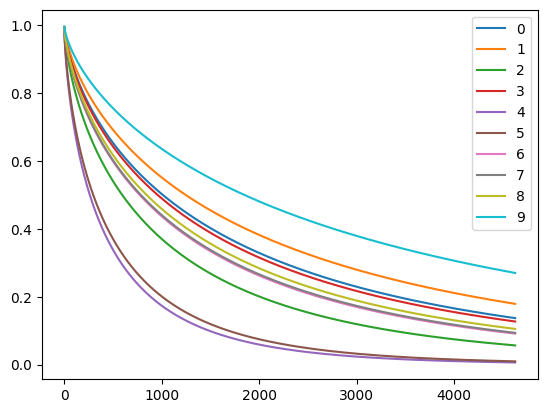

In [20]:
aft.predict_survival_function(_df_test.iloc[:10]).plot()

#### **RSF**

In [21]:
df_train , df_test , df_val = train_test_splitter(pats_all_metrics)

numeric_preprocessing = Pipeline(steps=[('imputing' , SimpleImputer())])
numeric_features = list(pats_all_metrics.iloc[: , :-2].columns)

null_preprocessing = Pipeline(steps = [('nothing' , None)])
null_features = ['time_to_event' , 'death']

preprocessing = ColumnTransformer(transformers=[
    ('numeric' , numeric_preprocessing , numeric_features),
    ('nothing', null_preprocessing , null_features)
    ]
)

train_ppln = Pipeline(steps=[('preprocessing', preprocessing)])
test_ppln = Pipeline(steps=[('preprocessing', preprocessing)])
val_ppln = Pipeline(steps=[('preprocessing', preprocessing)])

_df_train = pd.DataFrame(train_ppln.fit_transform(df_train) , columns = pats_all_metrics.columns)
_df_test = pd.DataFrame(test_ppln.fit_transform(df_test) , columns = pats_all_metrics.columns)
_df_val = pd.DataFrame(val_ppln.fit_transform(df_val) , columns = pats_all_metrics.columns)

In [22]:
# Train
X_train = _df_train[['temperature','heartrate','resprate','o2sat','sbp','dbp','anchor_age','gender']]
_df_train['death_bool'] = _df_train['death'].astype('bool')
y_train = np.rec.array(_df_train[['death_bool' , 'time_to_event']].to_records(index=False))

# Test
X_test = _df_test[['temperature','heartrate','resprate','o2sat','sbp','dbp','anchor_age','gender']]
df_test['death_bool'] = df_test['death'].astype('bool')
y_test = np.rec.array(df_test[['death_bool' , 'time_to_event']].to_records(index=False))

# Val
X_val = _df_val[['temperature','heartrate','resprate','o2sat','sbp','dbp','anchor_age','gender']]
_df_val['death_bool'] = _df_val['death'].astype('bool')
y_val = np.rec.array(_df_val[['death_bool' , 'time_to_event']].to_records(index=False))

In [23]:
rsf = RandomSurvivalForest(
    n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=1234
)
rsf.fit(X_val, y_val)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, random_state=1234)

In [24]:
# Concordance
rsf.score(X_test, y_test) , rsf.score(X_val, y_val) ,# rsf.score(X_train, y_train)

(0.9507883867844562, 0.9554270126410563)

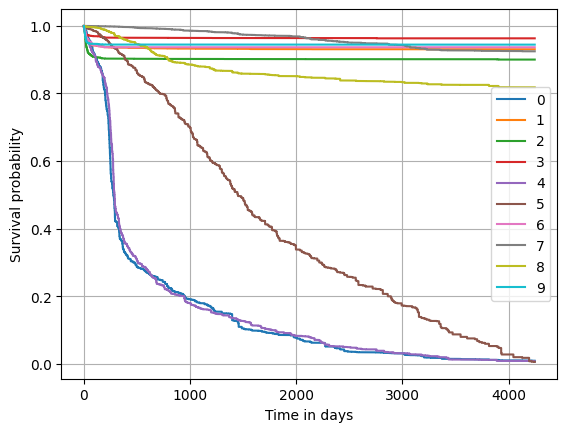

In [25]:
surv = rsf.predict_survival_function(X_train[:10], return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

In [26]:
rsf_surv_test = rsf.predict_survival_function(X_test, return_array=True)

rsf_surv_test.shape

(2579, 1242)

In [27]:
# ev_rsf = EvalSurv(pd.DataFrame(rsf_surv_test.T) , durations_test , events_test , censor_surv = 'km')

In [28]:
# print(ev_rsf.concordance_td('antolini'))

# time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
# ev_rsf.brier_score(time_grid).plot()
# plt.ylabel('Brier score')
# _ = plt.xlabel('Time')

# print(f'integrated brier score {ev_rsf.integrated_brier_score(time_grid) }')

#### **PyCox**

In [29]:
df_train , df_test , df_val = train_test_splitter(pats_all_metrics)

numeric_preprocessing = Pipeline(steps=[('imputing' , SimpleImputer()) , ('scaling' , StandardScaler())])
numeric_features = ['temperature','heartrate','resprate','o2sat','sbp','dbp','anchor_age']

categorical_preprocessing = Pipeline(steps=[('label_encoding' , ModifiedLabelEncoder())])
categorical_features = ['gender']

null_preprocessing = Pipeline(steps = [('nothing' , None)])
null_features = ['time_to_event' , 'death']

_col = ['temperature','heartrate','resprate','o2sat','sbp','dbp','anchor_age','gender','time_to_event' , 'death'] 

preprocessing = ColumnTransformer(transformers=[
    ('numeric' , numeric_preprocessing , numeric_features),
    ('categorical' , categorical_preprocessing , categorical_features), 
    ('nothing', null_preprocessing , null_features)
    ]
)

train_ppln = Pipeline(steps=[('preprocessing', preprocessing)])
test_ppln = Pipeline(steps=[('preprocessing', preprocessing)])
val_ppln = Pipeline(steps=[('preprocessing', preprocessing)])

_df_train = pd.DataFrame(train_ppln.fit_transform(df_train) , columns = _col)
_df_test = pd.DataFrame(test_ppln.fit_transform(df_test) , columns = _col)
_df_val = pd.DataFrame(val_ppln.fit_transform(df_val) , columns = _col)

# # Train
X_train = _df_train[['temperature','heartrate','resprate','o2sat','sbp','dbp','anchor_age','gender']]
# # _df_train['death_bool'] = _df_train['death'].astype('bool')
# # y_train = np.rec.array(_df_train[['death_bool' , 'time_to_event']].to_records(index=False))

# # Test
X_test = _df_test[['temperature','heartrate','resprate','o2sat','sbp','dbp','anchor_age','gender']]
# # df_test['death_bool'] = df_test['death'].astype('bool')
# # y_test = np.rec.array(df_test[['death_bool' , 'time_to_event']].to_records(index=False))

# # Val
X_val = _df_val[['temperature','heartrate','resprate','o2sat','sbp','dbp','anchor_age','gender']]
# # _df_val['death_bool'] = _df_val['death'].astype('bool')
# # y_val = np.rec.array(_df_val[['death_bool' , 'time_to_event']].to_records(index=False))

c:\Users\soura\Documents\ECMM451\project_env\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\soura\Documents\ECMM451\project_env\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\soura\Documents\ECMM451\project_env\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [30]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)

get_target = lambda df: (df['time_to_event'].values, df['death'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (X_train.to_numpy().astype('float32'), y_train)
val = (X_val.to_numpy().astype('float32'), y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

0:	[0s / 0s],		train_loss: 1.1123,	val_loss: 0.7215
1:	[0s / 0s],		train_loss: 0.7095,	val_loss: 0.7057
2:	[0s / 0s],		train_loss: 0.7063,	val_loss: 0.7060
3:	[0s / 0s],		train_loss: 0.7005,	val_loss: 0.7047
4:	[0s / 0s],		train_loss: 0.6974,	val_loss: 0.7042
5:	[0s / 1s],		train_loss: 0.6961,	val_loss: 0.7066
6:	[0s / 1s],		train_loss: 0.6943,	val_loss: 0.7065
7:	[0s / 1s],		train_loss: 0.6928,	val_loss: 0.7088
8:	[0s / 1s],		train_loss: 0.6925,	val_loss: 0.7056
9:	[0s / 1s],		train_loss: 0.6873,	val_loss: 0.7053
10:	[0s / 1s],		train_loss: 0.6889,	val_loss: 0.7072
11:	[0s / 1s],		train_loss: 0.6867,	val_loss: 0.7045
12:	[0s / 1s],		train_loss: 0.6829,	val_loss: 0.7073
13:	[0s / 1s],		train_loss: 0.6879,	val_loss: 0.7071
14:	[0s / 1s],		train_loss: 0.6845,	val_loss: 0.7096


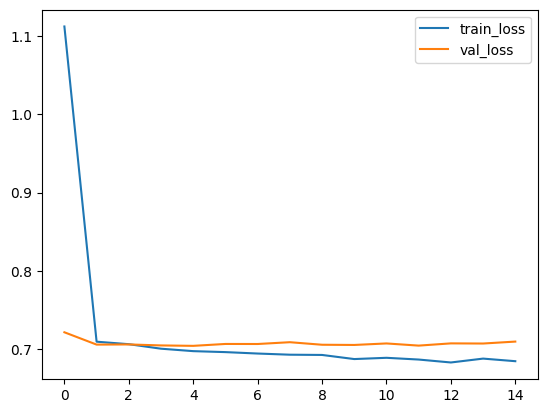

In [31]:
in_features = X_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

log = model.fit(X_train.to_numpy().astype('float32'), y_train, batch_size, epochs, callbacks, val_data=val)

_ = log.plot()

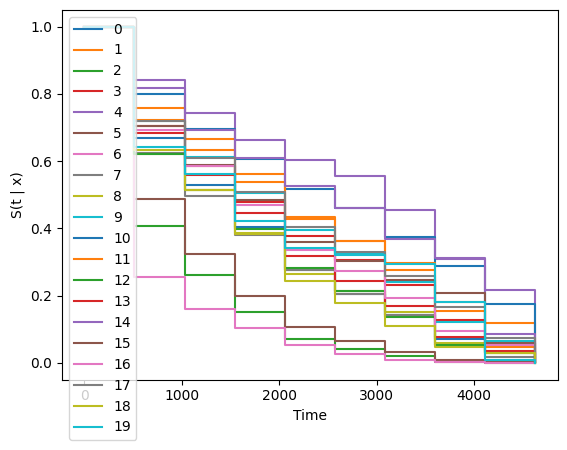

In [32]:
surv = model.predict_surv_df(X_test.to_numpy().astype('float32'))

surv.iloc[:, :20].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

shapes : (2579, 2579, 2579, 2579)
td-concordance 0.49588163319459666
integrated brier score 0.16774335150509584


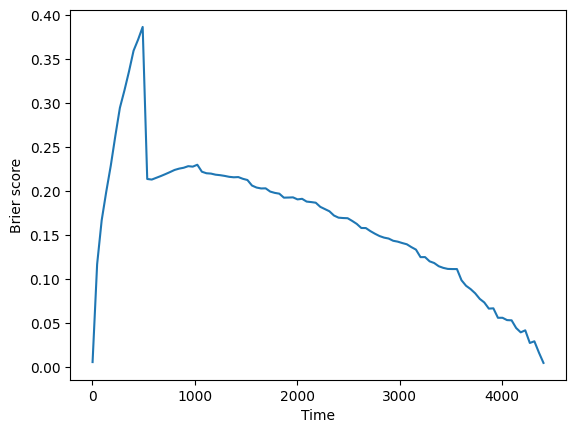

In [33]:
from eval_surv_copy import EvalSurv
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
print(f"td-concordance {ev.concordance_td('antolini')}")

time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

print(f'integrated brier score {ev.integrated_brier_score(time_grid) }')

#### **My Model**

In [34]:
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sksurv.metrics import concordance_index_ipcw , integrated_brier_score , brier_score
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
import torch
import torchtuples as tt
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong
from pycox.models import LogisticHazard

from eval_surv_copy import EvalSurv

# vars
q_cuts = 10
_cuts = 20

In [35]:
class generic_Loss(torch.nn.Module):
    '''
    Generic Loss Function
    '''
    def __init__(self, reduction: str = 'mean') -> None:
        super().__init__()
        self.reduction = reduction

    def nll_logistic_hazard(self , logits , targets , dur_idx):
        '''
        logits - parameterized inv.logit(hazards) from nn
        targets - survival matrix 
        '''
        logits = torch.Tensor(logits)
        targets = torch.Tensor(targets)
        dur_idx = torch.Tensor(dur_idx).to(torch.int64).view(-1 , 1)

        loss = F.binary_cross_entropy_with_logits(input = logits , target = targets , reduction = 'none')
        
        assert loss.shape == targets.shape , 'must match'

        # cumulative hazards
        loss = loss.cumsum(1)
        loss = loss.gather(1, dur_idx)
        
        return loss.view(-1).mean()

In [36]:
class MLP(nn.Module):
    def __init__(self , input_size , hidden_size , output_size , dropout_rate = 0.1):
        super(MLP , self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size), nn.ReLU(), nn.BatchNorm1d(hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.BatchNorm1d(hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.BatchNorm1d(hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.BatchNorm1d(hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self , x):
        # forward pass
        output = self.network(torch.Tensor(x).to(torch.float32))
        return output   

In [37]:
class MyDataset(Dataset):
    '''
    simple data set class
    '''
    def __init__(self, features, durations, events):
        self.data = features
        self.durations = durations
        self.events = events
        assert self.data.shape[0] == self.durations.shape[0] == self.durations.shape[0] , 'shapes must match!'

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        cov = self.data[index] # covariates
        dur = self.durations[index] # durations
        eve = self.events[index] # events
        return cov , dur , eve

In [38]:
class Surv_Matrix:
    def __init__(self , duration_index , events , cuts=10):
        self.duration_index = duration_index
        self.events = events
        self.q_cuts = q_cuts
    
    def make_survival_matrix(self):
        '''
        converts durations and index into a matrix denoting time of event
        this is the y_ij matrix as shown in Kvamme's paper
        '''
        self.surv_matrix = torch.eye(self.q_cuts)[self.duration_index] 
        self.surv_matrix = self.surv_matrix*self.events.reshape(-1 , 1) # censoring mask
        return self.surv_matrix

In [39]:
class Transforms:
    def __init__(self , durations):
        self.durations = durations
        # self.events = events
        
    def discrete_q_transform(self , q_cuts=10):
        '''
        cut at quantiles
        '''
        self.quantiles = np.linspace(0 , 1 , q_cuts)
        self.bin_edges = np.quantile(self.durations , self.quantiles) # right-side edges of the bins
        self.duration_index = np.searchsorted(a = self.bin_edges , v = self.durations)
        self.n_duration_index = len(np.unique(self.duration_index))
        # print(self.n_duration_index)
        assert self.n_duration_index == q_cuts , 'must match'
        return self.duration_index
    
    def discrete_transform(self , _cuts):
        '''
        cut at even spaces
        '''
        self.bin_edges = np.linspace(self.durations.min() , self.durations.max() , _cuts) # right-side edges of the bins
        self.duration_index = np.searchsorted(a = self.bin_edges , v = self.durations)
        self.n_duration_index = self.duration_index.max()+1
        # print(self.n_duration_index)
        assert self.n_duration_index == _cuts , 'must match'
        return self.duration_index

In [40]:
get_target = lambda df: (df['time_to_event'].values, df['death'].values)
y_train_dur , y_train_event = get_target(df_train)
y_test_dur , y_test_event = get_target(df_test)
y_val_dur , y_val_event = get_target(df_val)

In [122]:
t = Transforms(durations = y_train_dur)
dur_idx = t.discrete_transform(_cuts = q_cuts)

t_test = Transforms(durations = y_test_dur)
dur_idx_test = t_test.discrete_transform(_cuts = q_cuts)

t_val = Transforms(durations = y_val_dur)
dur_idx_val = t_val.discrete_transform(_cuts = q_cuts)

_comp = X_train.shape[1]

pca = PCA(n_components = _comp)
fit_pca = pca.fit(X_train)
x_train = fit_pca.transform(X_train)
# reduced_features = fit_pca.transform(x_train)

pca_test = PCA(n_components = _comp)
fit_pca_test = pca_test.fit(X_test)
x_test = fit_pca_test.transform(X_test)
# reduced_features_test = fit_pca_test.transform(x_test)

pca_val = PCA(n_components = _comp)
fit_pca_val = pca_val.fit(X_val)
x_val = fit_pca_val.transform(X_val)
# reduced_features_val = fit_pca_val.transform(x_val)
print(f'x_val shape: {x_val.shape}')

x_val shape: (3223, 8)


In [111]:
input_size = x_train.shape[1]
hidden_size = 32
output_size = t.n_duration_index


# Create an instance of your custom dataset
dataset = MyDataset(x_train, dur_idx , y_train_event) # need to change outcomes[0] to indexed version

# Create a data loader for batching and shuffling
batch_size = 256
num_epochs = 500
learning_rate = 0.01
shuffle = True
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
patience = 10

# build net
net = MLP(input_size , hidden_size , output_size)

# init optim
optimizer = torch.optim.Adam(net.parameters() , lr = learning_rate)

In [112]:
sm_val = Surv_Matrix(duration_index = dur_idx_val , events = y_val_event , cuts = q_cuts)
surv_mat_val = sm_val.make_survival_matrix()

l = generic_Loss()

best_loss = np.Inf

# Training loop
for epoch in range(num_epochs):
    for batch_id , (patient_image , dur , eve) in enumerate(dataloader):
        # Prime for training
        net.train()
        
        # forward pass
        phi_train = net(patient_image)

        # make survival matrix
        sm = Surv_Matrix(duration_index = dur, events = eve , cuts = q_cuts)
        surv_mat = sm.make_survival_matrix()        

        # get loss
        loss = l.nll_logistic_hazard(logits = phi_train , targets = surv_mat , dur_idx = dur)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Early stopping
        # Prime for evaluation
        net.eval()
        with torch.no_grad():
            phi_val = net(x_val)
            val_loss = l.nll_logistic_hazard(logits = phi_val, targets = surv_mat_val , dur_idx = dur_idx_val)
        
        # Check if validation loss has improved
        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
        else:
            counter += 1

        # Check if early stopping condition is met
        if counter >= patience:
            # print(f"Early stopping at epoch {epoch}.")
            break


    if (epoch%50==0): print(f"Epoch {epoch+1}: Training Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}") 

# turn training off
# net.eval()

Epoch 1: Training Loss: 1.0182, Val Loss: 1.0774
Epoch 51: Training Loss: 0.9422, Val Loss: 1.0289
Epoch 101: Training Loss: 0.9662, Val Loss: 1.0504
Epoch 151: Training Loss: 0.8556, Val Loss: 1.0322
Epoch 201: Training Loss: 0.9859, Val Loss: 1.0204
Epoch 251: Training Loss: 0.8727, Val Loss: 1.0265
Epoch 301: Training Loss: 0.8865, Val Loss: 1.0300
Epoch 351: Training Loss: 0.9593, Val Loss: 1.0111
Epoch 401: Training Loss: 0.9079, Val Loss: 1.0219
Epoch 451: Training Loss: 0.9497, Val Loss: 1.0070


In [113]:
with torch.no_grad():
    hazards = torch.sigmoid(net(x_test))
    survival = torch.log(1 - hazards).cumsum(1).exp()

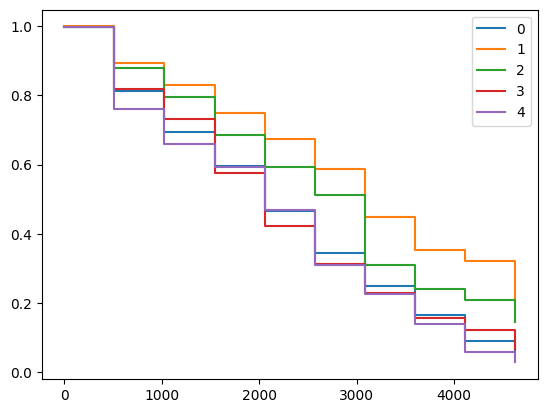

In [114]:
for i , surv in enumerate(survival.detach().numpy()[100:105]):
    plt.step(t.bin_edges , surv , where = 'post' , label = i)
    plt.legend()

shapes : (2579, 2579, 2579, 2579)
concordance-td: 0.5496646288039563
integrated brier score 0.2910341763200856


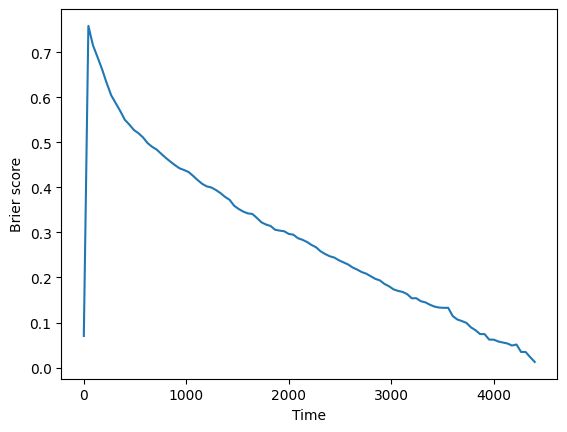

In [115]:
ev_ = EvalSurv(pd.DataFrame(survival.detach().numpy().T) , y_test_dur , y_test_event , censor_surv='km')
print(f'concordance-td: {ev_.concordance_td()}')


time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev_.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

print(f'integrated brier score {ev_.integrated_brier_score(time_grid) }')

#### **My Conv Net**

In [ ]:
conv_net = nn.Sequential(
                    nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1),
                    nn.ReLU(),
                    # # torch.Size([n_batch, 16, 100, 6]) |-> torch.Size([n_batch, 16, height, width])
                    nn.MaxPool1d(kernel_size=2, stride=1),
                    # # torch.Size([n_batch, 16, 99, 5]) |-> torch.Size([n_batch, 16, (height-kernel_size)/stride+1, (width-kernel_size)/stride+1])
                    nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),
                    nn.ReLU(),
                    # # torch.Size([n_batch, 32, 99, 5]) |-> torch.Size([n_batch, 32, height, width])
                    nn.MaxPool1d(kernel_size=2, stride=1),
                    # # torch.Size([n_batch, 32, 98, 4]) |-> torch.Size([n_batch, 32, (height-kernel_size)/stride+1, (width-kernel_size)/stride+1])
                    nn.Flatten()
                )

fc_net = nn.Sequential(
            nn.Linear(192, 100), nn.ReLU(), nn.BatchNorm1d(100), nn.Dropout(0.1),
            nn.Linear(100, 100), nn.ReLU(), nn.BatchNorm1d(100), nn.Dropout(0.1),
            nn.Linear(100, 10)
        )

input = torch.randn(256 , 1 , 8)

fc_net(conv_net(input)).shape
# conv_net(input).shape

torch.Size([256, 10])

In [116]:
class Conv_Net(nn.Module):
    def __init__(self , fc_input_size , fc_hidden_size , fc_output_size , dropout_rate=0.1):
        super(Conv_Net , self).__init__()
        # Convolutional Net
        # self.conv_net = nn.Sequential(
        #             nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
        #             nn.ReLU(),
        #             # torch.Size([n_batch, 16, 100, 6]) |-> torch.Size([n_batch, 16, height, width])
        #             nn.MaxPool2d(kernel_size=2, stride=1),
        #             # torch.Size([n_batch, 16, 99, 5]) |-> torch.Size([n_batch, 16, (height-kernel_size)/stride+1, (width-kernel_size)/stride+1])
        #             nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
        #             nn.ReLU(),
        #             # torch.Size([n_batch, 32, 99, 5]) |-> torch.Size([n_batch, 32, height, width])
        #             nn.MaxPool2d(kernel_size=2, stride=1),
        #             # torch.Size([n_batch, 32, 98, 4]) |-> torch.Size([n_batch, 32, (height-kernel_size)/stride+1, (width-kernel_size)/stride+1])
        #             nn.Flatten()
        #         )
        self.conv_net = nn.Sequential(
                    nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1),
                    nn.ReLU(),
                    # # torch.Size([n_batch, 16, 100, 6]) |-> torch.Size([n_batch, 16, height, width])
                    nn.MaxPool1d(kernel_size=2, stride=1),
                    # # torch.Size([n_batch, 16, 99, 5]) |-> torch.Size([n_batch, 16, (height-kernel_size)/stride+1, (width-kernel_size)/stride+1])
                    nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),
                    nn.ReLU(),
                    # # torch.Size([n_batch, 32, 99, 5]) |-> torch.Size([n_batch, 32, height, width])
                    nn.MaxPool1d(kernel_size=2, stride=1),
                    # # torch.Size([n_batch, 32, 98, 4]) |-> torch.Size([n_batch, 32, (height-kernel_size)/stride+1, (width-kernel_size)/stride+1])
                    nn.Flatten()
                )
        # Fully connected
        self.fc_net = nn.Sequential(
            nn.Linear(fc_input_size, fc_hidden_size), nn.ReLU(), nn.BatchNorm1d(fc_hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(fc_hidden_size, fc_hidden_size), nn.ReLU(), nn.BatchNorm1d(fc_hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(fc_hidden_size, fc_output_size)
        )
    
    def forward(self , x):
        # forward pass
        output = self.conv_net(x)
        # print(f'conv net output = {output.shape}')
        # print(f'shape after conv net: {output.shape}')
        output = self.fc_net(output)
        # print(f'shape after fc net: {output.shape}')
        return output

In [1]:
class MyDataset(Dataset):
    '''
    simple data set class
    '''
    def __init__(self, features, durations, events):
        self.data = features
        self.durations = durations
        self.events = events
        assert self.data.shape[0] == self.durations.shape[0] == self.durations.shape[0] , 'shapes must match!'

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        cov = self.data[index] # covariates
        dur = self.durations[index] # durations
        eve = self.events[index] # events
        return cov , dur , eve

NameError: name 'Dataset' is not defined

In [117]:
input_size = x_train.shape[1]
hidden_size = 32
output_size = t.n_duration_index

# Create an instance of your custom dataset
dataset = MyDataset(torch.Tensor(x_train).to(torch.float32), dur_idx , y_train_event) # need to change outcomes[0] to indexed version

# Create a data loader for batching and shuffling
batch_size = 256
num_epochs = 500
learning_rate = 0.01
shuffle = True
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
patience = 10

# build net
# net = MLP(input_size , hidden_size , output_size)
conv_net = Conv_Net(fc_input_size =  192, 
                    fc_hidden_size = 100 , 
                    fc_output_size = output_size,
                    dropout_rate = 0.1
                    )

# init optim
optimizer = torch.optim.Adam(net.parameters() , lr = learning_rate)

In [118]:
sm_val = Surv_Matrix(duration_index = dur_idx_val , events = y_val_event , cuts = q_cuts)
surv_mat_val = sm_val.make_survival_matrix()

l = generic_Loss()

best_loss = np.Inf

# Validation set reshape and type cast
x_val = x_val.reshape(x_val.shape[0] , 1 , x_val.shape[1])
x_val = torch.Tensor(x_val).to(torch.float32)
print(f'x_val shape: {x_val.shape}')

# Training loop
for epoch in range(num_epochs):
    for batch_id , (patient_image , dur , eve) in enumerate(dataloader):
        # Prime for training
        conv_net.train()

        patient_image = patient_image.view(patient_image.shape[0] , 1 , patient_image.shape[1]) 

        # forward pass
        phi_train = conv_net(patient_image)

        # make survival matrix
        sm = Surv_Matrix(duration_index = dur, events = eve , cuts = q_cuts)
        surv_mat = sm.make_survival_matrix()

        # get loss
        loss = l.nll_logistic_hazard(logits = phi_train , targets = surv_mat , dur_idx = dur)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Early stopping
        # Prime for evaluation
        conv_net.eval()
        with torch.no_grad():
            phi_val = conv_net(x_val)
            val_loss = l.nll_logistic_hazard(logits = phi_val, targets = surv_mat_val , dur_idx = dur_idx_val)
        
        # Check if validation loss has improved
        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
        else:
            counter += 1

        # Check if early stopping condition is met
        if counter >= patience:
            # print(f"Early stopping at epoch {epoch}.")
            break


    if (epoch%50==0): print(f"Epoch {epoch+1}: Training Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}") 

# turn training off
# net.eval()

x_val shape: (3223, 8)


Epoch 1: Training Loss: 1.7978, Val Loss: 2.0374
Epoch 51: Training Loss: 1.9705, Val Loss: 2.0795
Epoch 101: Training Loss: 1.9722, Val Loss: 2.0517
Epoch 151: Training Loss: 1.9888, Val Loss: 2.0445
Epoch 201: Training Loss: 2.0250, Val Loss: 2.0459
Epoch 251: Training Loss: 2.0460, Val Loss: 2.0490
Epoch 301: Training Loss: 1.9424, Val Loss: 2.0409
Epoch 351: Training Loss: 2.0225, Val Loss: 2.0347
Epoch 401: Training Loss: 1.9665, Val Loss: 2.0362
Epoch 451: Training Loss: 1.8977, Val Loss: 2.0483


x_test shape: torch.Size([2579, 1, 8])


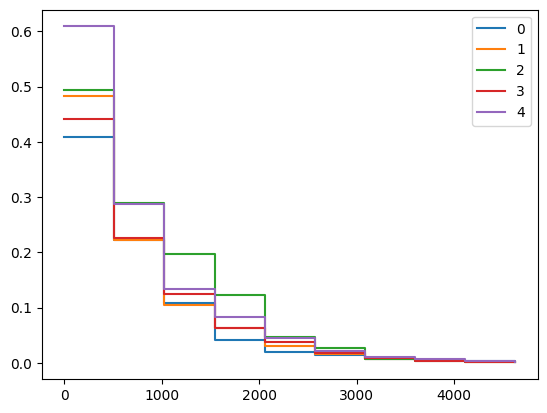

In [123]:
x_test = x_test.reshape(x_test.shape[0] , 1 , x_test.shape[1])
x_test = torch.Tensor(x_test).to(torch.float32)
print(f'x_test shape: {x_test.shape}')

with torch.no_grad():
    hazards = torch.sigmoid(conv_net(x_test))
    survival = torch.log(1 - hazards).cumsum(1).exp()

for i , surv in enumerate(survival.detach().numpy()[100:105]):
    plt.step(t.bin_edges , surv , where = 'post' , label = i)
    plt.legend()

shapes : (2579, 2579, 2579, 2579)
concordance-td: 0.5517683651019256
integrated brier score 0.33456162379401705


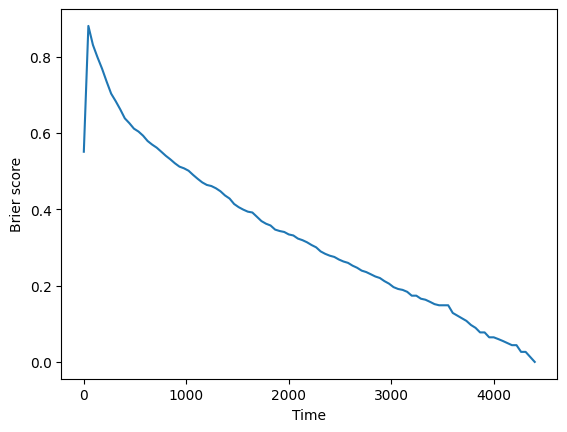

In [124]:
ev_ = EvalSurv(pd.DataFrame(survival.detach().numpy().T) , y_test_dur , y_test_event , censor_surv='km')
print(f'concordance-td: {ev_.concordance_td()}')

time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev_.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

print(f'integrated brier score {ev_.integrated_brier_score(time_grid) }')